In [1]:
# https://www.kaggle.com/code/bguberfain/elastic-transform-for-data-augmentation/notebook
# https://gist.github.com/erniejunior/601cdf56d2b424757de5
import warnings
warnings.filterwarnings('ignore')
import time
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import skimage.io
from skimage import color
from skimage import io
import glob
import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
import staintools
from tqdm import tqdm
import tifffile
import sys
import os
import numpy as np
from scipy import interpolate
from scipy.ndimage import morphology
from scipy.stats import multivariate_normal
from PIL import Image, ImageDraw
from cv2 import GaussianBlur, blur, getPerspectiveTransform, warpPerspective
from hashlib import blake2s
import imgaug as ia
import imgaug.augmenters as iaa
from deconvolution import Deconvolution
import deconvolution.pixeloperations as po
from albumentations.augmentations.transforms import HorizontalFlip
from albumentations.augmentations.transforms import VerticalFlip
from albumentations.augmentations.transforms import Transpose
import torch
from torch import nn
import torch.cuda.amp as amp
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler 
from torch.utils.data import SequentialSampler
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import tifffile
from fastai.vision.all import *
import Augmentor

from collections import defaultdict
sys.path.append("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/histopath_failure_modes")
from image_manipulation import img_manip

In [2]:
TRAIN_CSV = "/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train.csv"
df = pd.read_csv(TRAIN_CSV)

df_lung = df[df['organ'] == 'lung'].reset_index()
df_lung.__len__(), df['organ'].value_counts()

(48,
 kidney            99
 prostate          93
 largeintestine    58
 spleen            53
 lung              48
 Name: organ, dtype: int64)

In [18]:
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [4]:
def horizontal_flip(image, mask):

    transform = HorizontalFlip(p=1.0)
    augmented_image = transform(image=image, mask=mask)
    image  = augmented_image['image']
    mask  = augmented_image['mask']
    return image, mask

def vertical_flip(image, mask):

    transform = VerticalFlip(p=1.0)
    augmented_image = transform(image=image, mask=mask)
    image  = augmented_image['image']
    mask  = augmented_image['mask']
    return image, mask


def bubble_aug(image, mask):

    im_pil = Image.fromarray(image)
    img_with_bubbles = img_manip.add_bubbles(im_pil, alpha=0.55, maxWidth = 120, nBubbles = 150)
    image = np.array(img_with_bubbles)

    return image, mask


def stain_aug(image, mask):

    im_pil = Image.fromarray(image)
    image_with_stain = img_manip.add_stain(im_pil, adjFactor = [1.5, 0.2, 1.0],scaleMax = [3,3,1.5], scaleMin = [1.25,1.25,1],random_seed = None)
    image = np.array(image_with_stain)

    return image, mask

def sectioning_aug(image, mask):

    im_pil = Image.fromarray(image)
    image_with_sectioning = img_manip.add_sectioning(im_pil,endEdge = 2, nPts=2)
    image = np.array(image_with_sectioning)

    return image, mask

def clahe_aug(image, mask):
    
    h,w= mask.shape

    seq = iaa.Sequential([
        iaa.AllChannelsCLAHE(clip_limit=(1, 10))
    ], random_order=True)

    image, segmaps = seq(image=image, segmentation_maps=mask.reshape(1,h,w,1))
    segmaps = segmaps.reshape(h,w)

    return image, segmaps

def transpose_flip(image, mask):
    transform = Transpose(p=1.0)
    augmented_image = transform(image=image, mask=mask)
    image  = augmented_image['image']
    mask  = augmented_image['mask']
    return image, mask

def image_ditails(image, message):
    
    print("\n =----------------------------")
    print(message)
    print("image type",type(image))
    print("image dtype",image.dtype)
    print("shape",image.shape)
    print("\n =----------------------------=")
    

def elastic_deform(image, mask):
    """
    i/p image shape: (3000,3000,3)
    i/p mask shape: (3000,3000,1)

    o/p image shape: (3000,3000,3)
    o/p mask shape: (3000,3000,1)
    """
    
    p = Augmentor.DataPipeline([[np.array(image),np.array(mask)]])

    p.shear(1, max_shear_left = 3, max_shear_right = 3)
    p.skew(0.4, 0.5)

    
    images_aug = p.sample(1)
    
    augmented_image = images_aug[0][0]
    augmented_mask = images_aug[0][1]
    # print("inside elastic deform", augmented_mask.shape)
    # print("inside elastic deform", augmented_image.shape)

    return augmented_image, augmented_mask

In [5]:
image_size = 512
TRAIN = '/home/lakshita/somusan/hubmap_kaggle/nbs/hubmap-22-aug-pixel-size'
class HubmapDataset(Dataset):
    def __init__(self, df, augment=None):

        self.df = df
        self.augment = augment
        self.length = len(self.df)
        self.organ_to_label = {'kidney' : 0,
                               'prostate' : 1,
                               'largeintestine' : 2,
                               'spleen' : 3,
                               'lung' : 4}

    def __str__(self):
        string = ''
        string += '\tlen = %d\n' % len(self)

        d = self.df.organ.value_counts().to_dict()
        for k in ['kidney', 'prostate', 'largeintestine', 'spleen', 'lung']:
            string +=  '%24s %3d (%0.3f) \n'%(k, d.get(k,0), d.get(k,0)/len(self.df))
        return string

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        d = self.df.iloc[index]
        img_height = self.df.loc[index, 'img_height']
        img_width = self.df.loc[index, 'img_width']
        organ = self.organ_to_label[d.organ]

        image = cv2.cvtColor(cv2.imread(os.path.join(TRAIN, f'{d.id}.png')), cv2.COLOR_BGR2RGB).astype(np.uint8)
        
        rle_mask = self.df.loc[index, 'rle']
        mask = rle_decode(rle_mask, (img_height, img_width)).astype(np.uint8)
        # mask = np.expand_dims(mask, axis = 2)

        if self.augment is not None:
            image, mask = self.augment(image, mask, organ)

        # mask = np.expand_dims(mask, axis = 0)
        # print("inside dataclass")
        # print(image.shape, mask.shape)
        r ={}
        r['index']= index
        r['image'] = image
        r['mask' ] = mask
        r['id'] = d.id

        return r

In [6]:
def train_augment5b(image, mask, organ):
    
    for fn in np.random.choice([
        lambda image, mask: (image, mask),
        lambda image, mask: horizontal_flip(image, mask),
        lambda image, mask: transpose_flip(image, mask),
        lambda image, mask: vertical_flip(image, mask),
    ], 2, p=[0.1,0.3, 0.3, 0.3]): image, mask = fn(image, mask)

    for fn in np.random.choice([
        lambda image, mask: (image, mask),
        lambda image, mask: elastic_deform(image, mask),
    ], 1, p=[0.25, 0.75]): image, mask = fn(image, mask)


    for fn in np.random.choice([
        lambda image, mask: (image, mask),
        lambda image, mask: clahe_aug(image, mask),
        lambda image, mask: sectioning_aug(image, mask),
        lambda image, mask: stain_aug(image, mask),
    ], 2, p=[0.35, 0.15, 0.3, 0.2]): image, mask = fn(image, mask)

    for fn in np.random.choice([
        lambda image, mask: (image, mask),
        lambda image, mask: bubble_aug(image, mask),
    ], 1, p=[0.4, 0.6]): image, mask = fn(image, mask)

    return image, mask

In [7]:
df = pd.read_csv("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train.csv")
df = df[df['organ']=='lung'].reset_index()
train_dataset = HubmapDataset(df, train_augment5b)


# train_loader = torch.utils.data.DataLoader(
#                dataset=train_dataset,
#                batch_size=4,
#                shuffle=False,
#                num_workers=2)

In [8]:
# img_ = train_dataset[0]['image']
# mask_ = train_dataset[0]['mask']
# img_.shape, mask_.shape
from tqdm import tqdm

dir = "/home/lakshita/somusan/hubmap_kaggle/nbs/hubmap-22-aug-pixel-size"

dest_dir_img = '/home/lakshita/somusan/hubmap_kaggle/nbs/aug_lung_data/image'
dest_dir_mask = '/home/lakshita/somusan/hubmap_kaggle/nbs/aug_lung_data/mask'

os.makedirs(dest_dir_img, exist_ok=True) 
os.makedirs(dest_dir_mask, exist_ok=True) 



lung_idx = [i for i in range(len(df))]
for idx in tqdm(np.random.choice(lung_idx, 40)):
    img_ = train_dataset[idx]['image']
    mask_ = train_dataset[idx]['mask']
    id_ = train_dataset[idx]['id']

    fname_img = dest_dir_img + "/" + str(id_) + ".png"
    fname_mask = dest_dir_mask + "/" + str(id_) + ".png"

    cv2.imwrite(fname_img, img_)
    cv2.imwrite(fname_mask, mask_)

    # plt.figure(figsize=(14,16))
    # plt.imshow(img_);plt.imshow(mask_, alpha=0.3)
    # plt.show()

100%|██████████| 40/40 [3:40:45<00:00, 331.13s/it]  


### Image Name Fix:
- name fix
- add new ids to the csv

In [9]:
"""
take 1 img, take its index and file name, then new name = file_name + index
"""
import os
import glob
from tqdm import tqdm

# os.mkdirs("/home/lakshita/somusan/hubmap_kaggle/nbs/aug_lung_data/img")
img_file = "/home/lakshita/somusan/hubmap_kaggle/nbs/aug_lung_data/image"
msk_file = "/home/lakshita/somusan/hubmap_kaggle/nbs/aug_lung_data/mask"
for idx, (img_, msk_) in tqdm(enumerate(zip(glob.glob(img_file+"/*"), glob.glob(msk_file+"/*")))):
    new_id = img_.split('/')[-1].split(".")[0] + str(idx)
    new_img = img_file + "/" + new_id + ".png"
    new_msk = msk_file + "/" + new_id + ".png"

    os.rename(img_,new_img) 
    os.rename(msk_,new_msk) 
    


# deleted 823101

32it [00:00, 11961.30it/s]


In [38]:
import pandas as pd
import glob
import os
import cv2
import numpy as np


img_file = "/home/lakshita/somusan/hubmap_kaggle/nbs/aug_lung_data/image"
msk_file = "/home/lakshita/somusan/hubmap_kaggle/nbs/aug_lung_data/mask"

total_msk_paths = glob.glob(msk_file+"/*")
total_img_paths = glob.glob(img_file+"/*")

data_source = ["HPA" for i in range(len(total_img_paths))]
img_height = [cv2.imread(i).shape[0] for i in total_img_paths]
img_width = [cv2.imread(i).shape[1] for i in total_img_paths]
pixel_size = [0.4 for i in range(len(total_img_paths))]
tissue_thickness = [4 for i in range(len(total_img_paths))]
age = [22.0 for i in range(len(total_img_paths))]
sex = ["Male" for i in range(len(total_img_paths))]
organ = ["lung" for i in range(len(total_img_paths))]
id_ = []
for i in total_img_paths:
    id_.append(int(i.split("/")[-1].split('.')[0]))
    
rle = [rle_encode(cv2.imread(total_msk_paths[i],0)) for i in range(len(total_img_paths))]

In [52]:
df = pd.read_csv("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train.csv")
# df.head()

lung_df_dict = {
    "id": id_,
    "organ": organ,
    "data_source": data_source,
    "img_height": img_height,
    "img_width": img_width,
    "pixel_size": pixel_size,
    "tissue_thickness": tissue_thickness,
    "rle": rle,
    "age": age,
    "sex":sex
}

df_lung = pd.DataFrame.from_dict(lung_df_dict)
# df_lung.drop('Unnamed: 0', axis=0, inplace=True) 
# df_lung.head()

df_lung.to_csv('/home/lakshita/somusan/hubmap_kaggle/nbs/aug_lung_data/aug_lung.csv', index=False)

df_temp  = pd.read_csv("/home/lakshita/somusan/hubmap_kaggle/nbs/aug_lung_data/aug_lung.csv")
df_temp.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,311399,lung,HPA,3000,3000,0.4,4,1345440 2 1348438 2 1348442 1 1351436 2 135143...,22.0,Male
1,50867,lung,HPA,3000,3000,0.4,4,2200408 26 2203404 36 2206397 48 2209396 53 22...,22.0,Male
2,12204,lung,HPA,3000,3000,0.4,4,5240485 2 5240489 2 5243484 13 5246483 15 5249...,22.0,Male
3,2325210,lung,HPA,3000,3000,0.4,4,1483636 14 1486636 15 1489633 3 1489637 12 148...,22.0,Male
4,187828,lung,HPA,3000,3000,0.4,4,1685219 4 1688218 6 1691216 8 1694214 11 16972...,22.0,Male


In [53]:
df = pd.read_csv("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train.csv")
df_3 = pd.concat([df, df_lung], axis=0)
df_3.to_csv('/home/lakshita/somusan/hubmap_kaggle/nbs/aug_lung_data/aug_lug_all_train.csv', index=False)

In [56]:
# All lungs
lung_norma = df[df['organ']=='lung']
only_lung = pd.concat([lung_norma, df_lung], axis=0)
only_lung.to_csv('/home/lakshita/somusan/hubmap_kaggle/nbs/aug_lung_data/only_lung.csv', index=False)

In [106]:
original_lung_ids = []

for i in df_lung.iterrows():
    id_str = str(i[1].id)
    # print(id_str)
    if(len(id_str)) == 4:
        original_lung_ids.append(str(id_str[0:3]))
        # print("one from 4")
    elif(len(id_str)) == 5:
        original_lung_ids.append(str(id_str[0:3]))
        original_lung_ids.append(str(id_str[0:4]))
        # print("one from 5")
    elif(len(id_str)) == 6:
        original_lung_ids.append(str(id_str[0:4]))
        original_lung_ids.append(str(id_str[0:5]))
        # print("one from 6")
    elif(len(id_str)) == 7:
        original_lung_ids.append(str(id_str[0:5]))
        # print("one from 7")

augmented_id = []
for i in original_lung_ids:
    # print(i)
    if int(i) in df[df['organ']=='lung'].id.to_list():
        augmented_id.append(i)

with open('/home/lakshita/somusan/hubmap_kaggle/nbs/aug_lung_data/lung_aug_ids.txt', 'w') as filehandle:
    for listitem in augmented_id:
        filehandle.write('%s\n' % listitem)



# org_lung_size_set = set()

# for j in range(len(df[df['organ']=='lung'].id)):
#     org_lung_size_set.add(len(str(df[df['organ']=='lung'].id.iloc[j])))

# print(org_lung_size_set)
# size_set = set()
# for i in os.listdir("/home/lakshita/somusan/hubmap_kaggle/nbs/aug_lung_data/image"):
#     size_set.add(len(i.split('.')[0]))

# print(size_set)

In [ ]:
# df[df['organ']=='lung'].id.to_list()

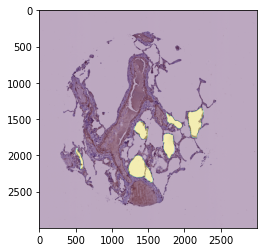

In [34]:
img_temp = plt.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train_images/5086.tiff")
msk_temp = plt.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/mask_png/train_binary_masks/5086.png")

plt.imshow(img_temp);plt.imshow(msk_temp, alpha=0.3)
plt.show()

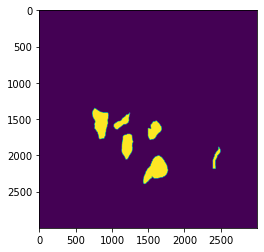

In [32]:
import matplotlib.pyplot as plt
rle_temp = rle_encode(cv2.imread(total_msk_paths[1],0))
plt.imshow(rle_decode(rle_temp, (3000,3000)))

In [17]:
# DELETE FILES WHICH ARE NOT LUNGS IMAGES
import pandas as pd
import os

df = pd.read_csv("/home/lakshita/somusan/hubmap_kaggle/nbs/aug_lung_data/only_lung.csv")
old_df = pd.read_csv("/home/lakshita/somusan/hubmap_kaggle/nbs/aug_lung_data/train.csv")

DIR = "/home/lakshita/somusan/hubmap_kaggle/nbs/aug_lung_data/hubmap-22-aug-pixel-size" # where all the images are

ids_tobe_deleted = [i for i in old_df['id'].to_list() if i not in df['id'].to_list()]
files_tobe_deleted = [DIR+'/'+str(i)+".png" for i in ids_tobe_deleted]

for file in files_tobe_deleted:
    if os.path.exists(file):
        os.remove(file) 

In [19]:
# DELETE FILES WHICH ARE NOT LUNGS MASKS
df = pd.read_csv("/home/lakshita/somusan/hubmap_kaggle/nbs/aug_lung_data/only_lung.csv")
old_df = pd.read_csv("/home/lakshita/somusan/hubmap_kaggle/nbs/aug_lung_data/train.csv")

DIR = "/home/lakshita/somusan/hubmap_kaggle/nbs/aug_lung_data/train_binary_masks"

ids_tobe_deleted = [i for i in old_df['id'].to_list() if i not in df['id'].to_list()]
files_tobe_deleted = [DIR+'/'+str(i)+".png" for i in ids_tobe_deleted]

for file in files_tobe_deleted:
    if os.path.exists(file):
        os.remove(file) 

In [23]:
# len(os.listdir("/home/lakshita/somusan/hubmap_kaggle/nbs/aug_lung_data/lung_images_aug_org")) #79
# df.__len__()# 79

79

# Extra part:
- this is where I test w/ the data loader if the overlay works

In [10]:
len(os.listdir("/home/lakshita/somusan/hubmap_kaggle/nbs/aug_lung_data/mask"))

32

In [ ]:
# cv2.imwrite('demo_img.png', img_)
# cv2.imwrite('demo_mask.png', mask_)

In [ ]:
img = cv2.cvtColor(cv2.imread("/home/lakshita/somusan/hubmap_kaggle/nbs/aug_lung_data/image/15329.png"), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(14,16))
plt.imshow(img);plt.imshow(cv2.imread('/home/lakshita/somusan/hubmap_kaggle/nbs/aug_lung_data/mask/15329.png',0), alpha= 0.4)
plt.show()

In [ ]:
"""
4 images[batch size] for bubble aug took 3min
4 images[batch size] for stain aug took 3min
4 images[batch size] for sectioning aug took 9 sec

with data loader it works like a charm, that means it also works w/o that
Net save them and run that effnet.
"""
items = next(iter(train_loader))
imgs = items["image"]
mask = items["mask"]

imgs.shape, mask.shape 

In [ ]:
imgs = items["image"]
msks = items["mask"]
print(imgs.size(), msks.size())


import matplotlib.pyplot as plt
def plot_batch(imgs, msks, size=3):
    for idx in range(size):
        plt.figure(figsize=(4*3, 5))

        print("debug plot batch img ",imgs[idx].shape)
        plt.subplot(1, 3, 1); plt.imshow(imgs[idx])
        plt.title('image', fontsize=15)
        plt.axis('OFF')
        print("debug plot batch ",msks[idx].shape)
        plt.subplot(1, 3, 2); plt.imshow(msks[idx])
        plt.title('mask', fontsize=15)
        plt.axis('OFF')
            
        plt.subplot(1, 3, 3); plt.imshow(imgs[idx]); plt.imshow(msks[idx], alpha=0.3)
        plt.title('overlay', fontsize=15)
        plt.axis('OFF')
        
        plt.tight_layout()
        plt.show()

plot_batch(imgs, msks, size=3)